# 손동작 분류 
- https://dacon.io/competitions/official/235876/overview/description
- xgboost  baseline
- https://wooono.tistory.com/97 : xgboost

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display 

from pytorchtools.pytorchtools import EarlyStopping # 현재 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.9.0  Device :  cuda


In [3]:
train=pd.read_csv("./data/train_std.csv")
train.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,-0.535371,-0.125639,0.341578,-0.451265,-0.258112,0.024504,-0.035601,-0.062341,0.495730,0.561387,...,-0.425023,-0.499626,-0.807129,0.271689,1.408115,-0.263322,-0.702508,-0.238269,-0.735616,1
1,-0.194913,-0.135612,0.192241,-0.699634,-0.070194,-0.409077,1.003842,-0.570637,-0.496736,-0.549809,...,-0.120779,-0.659965,-0.421554,0.338467,0.704214,0.847177,-0.129756,-0.155609,-0.974972,1
2,1.661792,-0.282778,0.035701,-1.403838,0.795608,2.440908,-0.784159,-1.021484,-0.750397,-0.809140,...,-0.416751,4.496282,-0.821026,0.468867,0.392232,-3.454223,-0.529888,-0.319460,-0.316562,0
3,-0.192544,-0.260938,0.825381,-0.197252,-0.020994,0.408111,-1.082022,0.012872,-0.086870,0.284354,...,-0.128610,-0.086139,0.292807,0.387015,-0.065044,-0.336256,-0.398988,-0.513363,-0.184111,1
4,0.344222,0.400669,-1.359199,0.057862,2.349527,1.504501,-0.817374,-0.766131,-1.742301,-0.541734,...,-0.124109,0.908166,0.256060,-0.501660,1.104734,0.180913,0.531208,0.469003,-1.661853,2


In [5]:
test=pd.read_csv("./data/test_std.csv")
test.head()

,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
0,1,0.005674,0.676368,-0.115694,-0.842619,-0.162445,-1.488116,0.071972,1.374886,0.669053,...,0.312165,0.385398,0.158167,-0.534629,0.035820,0.331942,-0.658255,0.549249,-0.077809,0.708034
1,2,0.582327,-1.611717,0.970755,2.533359,-0.398683,0.801910,0.307658,0.256059,0.337094,...,-0.304989,-1.779163,-1.418008,-1.520688,0.007826,0.454621,0.654006,-0.387429,2.187045,3.454621
2,3,-0.406466,0.129206,-0.073880,-0.401250,-0.330870,0.132228,0.503219,-0.590254,0.501513,...,-0.034375,-0.524039,-0.002156,0.405970,0.190804,-0.719914,-0.401736,-0.939436,0.110953,-0.200973
3,4,0.001535,-0.535835,0.468239,1.493656,-0.177808,-0.812185,0.084399,0.068180,0.090225,...,-0.387284,0.185620,0.075617,0.702048,1.574165,-0.077081,-0.100479,0.005149,-0.974656,-0.466246
4,5,-0.662690,-0.285824,0.307139,-0.582444,2.353133,-0.679244,-0.424087,-0.981423,-4.787554,...,-0.076846,-1.571478,-0.564297,0.113274,0.459036,0.206241,3.876766,0.407601,-0.697985,-0.448883


In [26]:
train

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,-0.535371,-0.125639,0.341578,-0.451265,-0.258112,0.024504,-0.035601,-0.062341,0.495730,0.561387,...,-0.425023,-0.499626,-0.807129,0.271689,1.408115,-0.263322,-0.702508,-0.238269,-0.735616,1
1,-0.194913,-0.135612,0.192241,-0.699634,-0.070194,-0.409077,1.003842,-0.570637,-0.496736,-0.549809,...,-0.120779,-0.659965,-0.421554,0.338467,0.704214,0.847177,-0.129756,-0.155609,-0.974972,1
2,1.661792,-0.282778,0.035701,-1.403838,0.795608,2.440908,-0.784159,-1.021484,-0.750397,-0.809140,...,-0.416751,4.496282,-0.821026,0.468867,0.392232,-3.454223,-0.529888,-0.319460,-0.316562,0
3,-0.192544,-0.260938,0.825381,-0.197252,-0.020994,0.408111,-1.082022,0.012872,-0.086870,0.284354,...,-0.128610,-0.086139,0.292807,0.387015,-0.065044,-0.336256,-0.398988,-0.513363,-0.184111,1
4,0.344222,0.400669,-1.359199,0.057862,2.349527,1.504501,-0.817374,-0.766131,-1.742301,-0.541734,...,-0.124109,0.908166,0.256060,-0.501660,1.104734,0.180913,0.531208,0.469003,-1.661853,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,-0.345718,5.393804,0.604643,-1.226100,0.703314,-9.695606,-1.486334,0.822807,-1.825879,2.023528,...,0.186695,-0.412164,-1.492652,-1.460590,1.999079,-0.352083,-1.753098,-0.203639,0.491784,3
2331,-0.262199,-0.548707,-0.039446,0.268665,-0.174773,-0.395801,-0.102970,-1.865555,-0.350308,-0.649167,...,0.415677,-0.011177,-0.116519,0.921653,-0.770691,0.170515,0.119370,1.139607,-0.053905,3
2332,-0.783697,0.808895,-0.307187,-0.701039,0.445133,1.112023,1.223604,-0.193449,-0.264206,-0.775251,...,-0.481061,0.170483,-0.782933,-1.465457,0.966048,0.099710,-1.490799,-0.278190,-0.057058,3
2333,-0.347194,0.406962,-0.450592,-0.245049,1.472717,-0.704114,0.341756,0.318000,-1.748022,-0.254789,...,0.186323,0.170921,-0.141426,-0.232203,-0.455245,-0.500671,-0.534043,0.589805,-0.741910,1


In [27]:
train_x=train.drop('target',axis=1)
train_y=train['target']

In [29]:
import xgboost as xgb
# 모델 선언
model = xgb.XGBClassifier() 
model.fit(train_x,train_y) 
y_pred = model.predict(test.drop('id',axis=1))

C:\Users\dlwhd\miniconda3\envs\localtorch\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:27:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [30]:
y_pred

array([0, 0, 1, ..., 2, 0, 3], dtype=int64)

In [31]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [33]:
submission['target']=y_pred
submission

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2
...,...,...
9338,9339,3
9339,9340,1
9340,9341,2
9341,9342,0


In [34]:
submission.to_csv('./submit.csv',index=False)

시각화

In [35]:
!pip install graphviz

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

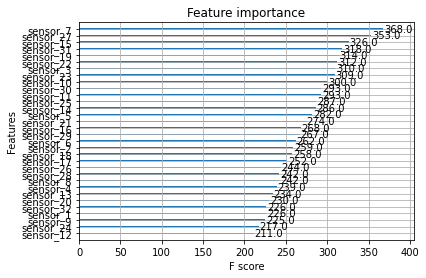

In [37]:
import xgboost as xgb

xgb.plot_importance(model)